# Model Building

## Importing Model Building Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
from sklearn.ensemble import VotingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import feature_selection
from sklearn.inspection import permutation_importance

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss,r2_score
from sklearn.metrics import average_precision_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, plot_roc_curve, f1_score, fbeta_score

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.combine import SMOTEENN
import pickle

## Loading Dataset

In [3]:
df = pd.read_csv("C:/Users/Soham Navale/Final_Project_churn/Telecomm-churn-retention-data-result.csv")

### Splitting the Dataset into test and train

In [4]:
#df=df.drop('Unnamed: 0',axis=1)

In [5]:
x = df.drop(columns = "customerstatus")
y = df["customerstatus"].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 11)

In [7]:
col=['totalcharges','avgmonthlylongdistancecharges','monthlycharge','totalrevenue',
     'totallongdistancecharges','totalextradatacharges']

*Standardization of a dataset is a common requirement for many machine learning estimators therefore, Standard Scalar is used for standardization.*

In [8]:
scaler = StandardScaler()
X_train[col] = StandardScaler().fit_transform(X_train[col])
X_test[col] = StandardScaler().fit_transform(X_test[col])

# Model Building Without Optimization 
*Since its a binary Classification Problem. So I have tried to build several classification models. At first I have just used the base models and have evaluated them to check how they are performing*

In [9]:
models = []
models.append(('Random Forest Classifier', RandomForestClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('XGB Classifier',XGBClassifier()))
models.append(('KNN Classifier', KNeighborsClassifier()))


In [10]:
acc_results =[]
auc_results =[]
pre_results =[]
f1_results =[]
names = []

result_col = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "f1 Score"]
model_results = pd.DataFrame(columns = result_col)

i=0
# K- fold cross validation

for name, model in models:
    names.append(name)
    # kfold = model_selection.KFold(n_splits=10)
    
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, 
                     scoring="accuracy")
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train,
                     scoring="roc_auc")
    cv_pre_results = model_selection.cross_val_score(model, X_train, y_train,
                     scoring="precision")
    cv_f1_results = model_selection.cross_val_score(model, X_train, y_train,
                     scoring="f1")
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [name, 
                           round(cv_acc_results.mean()*100,2),
                           round(cv_auc_results.mean()*100,2),
                           round(cv_pre_results.mean()*100,2),
                           round(cv_f1_results.mean()*100,2)]
    i+=1

model_results.sort_values(by = ['Accuracy'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,f1 Score
2,XGB Classifier,82.79,59.75,68.48,24.34
0,Random Forest Classifier,76.34,57.15,31.06,25.88
1,Decision Tree Classifier,71.56,55.09,26.51,27.43
3,KNN Classifier,78.14,53.40,23.96,11.71


*As you can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.*

*Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low.*

*Hence, moving ahead to call SMOTEENN (UpSampling + ENN) and finding good hyper parameters for best accuracy, precision, recall & f1 score*

## SMOTEENN

In [11]:
sm = SMOTEENN(random_state=11)
X_resampled, y_resampled = sm.fit_resample(x,y)


In [12]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.3, random_state = 11)

# Finding Good Hyper Parameters for various Models

## Decision Tree Classifier

In [13]:
modelDTC= DecisionTreeClassifier()
modelDTC.fit(xr_train, yr_train) 

DecisionTreeClassifier()

In [14]:
pred_train_DTC = modelDTC.predict(xr_train)
pred_test_DTC=modelDTC.predict(xr_test)

In [15]:
acc_train_DTC = accuracy_score(pred_train_DTC, yr_train)
acc_test_DTC = accuracy_score(pred_test_DTC, yr_test)
print(f'Training accuracy {acc_train_DTC: .3f}') 
print(f'Testing accuracy {acc_test_DTC: .3f}')

Training accuracy  1.000
Testing accuracy  0.821


### Tuning The Parameters

In [16]:
# hyperparameters to tune
tuned_parameters = [{'criterion':['gini', 'entropy','log_loss'], 
                     'max_depth': range(10,25), 
                     'max_features' : ['auto', 'sqrt', 'log2']}] 
# grid search model
clf_DTC = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, 
                   verbose=1, n_jobs=-1) 
 # evaluate hyper-parameters
clf_DTC.fit(xr_train, yr_train)

# best hyperparameter values
print("\nBest parameters found:")
print(clf_DTC.best_params_) 

print("\nGrid scores:")
means_DTC = clf_DTC.cv_results_['mean_test_score'] # mean accuracy with folds
stds_DTC = clf_DTC.cv_results_['std_test_score'] # standard deviation of accuracies

# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means_DTC, stds_DTC, clf_DTC.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 135 candidates, totalling 675 fits

Best parameters found:
{'criterion': 'entropy', 'max_depth': 17, 'max_features': 'sqrt'}

Grid scores:
0.784 (+/-0.011) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto'}
0.775 (+/-0.028) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}
0.777 (+/-0.012) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
0.792 (+/-0.016) for {'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto'}
0.790 (+/-0.020) for {'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt'}
0.780 (+/-0.013) for {'criterion': 'gini', 'max_depth': 11, 'max_features': 'log2'}
0.804 (+/-0.016) for {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto'}
0.802 (+/-0.012) for {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt'}
0.787 (+/-0.022) for {'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2'}
0.802 (+/-0.017) for {'criterion': 'gini', 'max_depth': 13, 'max_features': '

DecisionTreeClassifier(criterion='entropy', max_depth=21, max_features='sqrt',
                       random_state=11)
Results on test data
Test accuracy =  0.8199
Test precision =  0.8587
Test recall =  0.8363
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      5642
           1       0.86      0.84      0.85      8387

    accuracy                           0.82     14029
   macro avg       0.81      0.82      0.81     14029
weighted avg       0.82      0.82      0.82     14029

Confusion matrix (Rows actual, Columns predicted):
      0     1
0  4488  1154
1  1373  7014

ROC curve


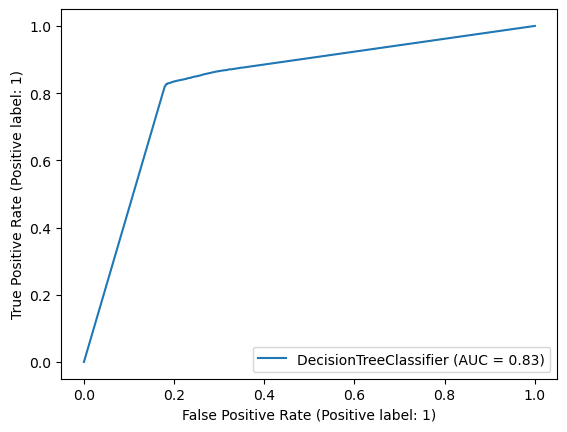

In [17]:
# Train and test model using hyper-parameters
good_model_DTC = DecisionTreeClassifier(criterion= 'entropy', max_features='sqrt',
                                        max_depth =  21, random_state = 11)

# create model 
print(good_model_DTC) # display model parameters
good_model_DTC.fit(xr_train, yr_train) # train model
pred_DTC = good_model_DTC.predict(xr_test) # predicted output for test examples

# print results
print("Results on test data")
acc_DTC = accuracy_score(yr_test, pred_DTC) # accuracy on test examples
prec_DTC = precision_score(yr_test, pred_DTC) # precision on test examples
reca_DTC = recall_score(yr_test, pred_DTC) # recall on test examples
print(f'Test accuracy = {acc_DTC: .4f}') # round to 4 decimal places
print(f'Test precision = {prec_DTC: .4f}') # round to 4 decimal places
print(f'Test recall = {reca_DTC: .4f}') # round to 4 decimal places

# print Classification report
print("Classification report:")
print(classification_report(yr_test, pred_DTC))

# print Confusion matrix
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(yr_test, pred_DTC)))

# print ROC curve
print('\nROC curve')
plot_roc_curve(good_model_DTC, xr_test, yr_test)  # 
plt.show()

## Random Forest model

In [18]:
modelRF = RandomForestClassifier()
modelRF.fit(xr_train, yr_train) 

RandomForestClassifier()

In [19]:
pred_train = modelRF.predict(xr_train)
pred_test=modelRF.predict(xr_test)

In [20]:
acc_train = accuracy_score(pred_train, yr_train)
acc_test = accuracy_score(pred_test, yr_test)
print(f'Training accuracy {acc_train: .3f}') 
print(f'Testing accuracy {acc_test: .3f}')

Training accuracy  1.000
Testing accuracy  0.851


#### Tuning the Parameters

In [21]:
# hyperparameters to tune
tuned_parameters = [{'n_estimators': [25,50,75],
                     'max_features': ['auto', 'sqrt'], 
                     'criterion' : ['log_loss','gini','entropy'],
                    'max_depth' : range(10,25)}] 

# grid search model
clfRF = GridSearchCV(RandomForestClassifier(), tuned_parameters, 
                   verbose=1, n_jobs=-1) 
# evaluate hyper-parameters
clfRF.fit(xr_train, yr_train) 

# best hyperparameter values
print("\nBest parameters found:")
print(clfRF.best_params_) 

print("\nGrid scores:")
means = clfRF.cv_results_['mean_test_score'] # mean accuracy with folds
stds = clfRF.cv_results_['std_test_score'] # standard deviation of accuracies

# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means, stds, clfRF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Best parameters found:
{'criterion': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 75}

Grid scores:
0.872 (+/-0.015) for {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 25}
0.872 (+/-0.006) for {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50}
0.876 (+/-0.010) for {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 75}
0.874 (+/-0.006) for {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 25}
0.874 (+/-0.013) for {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
0.876 (+/-0.007) for {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 75}
0.878 (+/-0.005) for {'criterion': 'log_loss', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 25}
0.879 (+/-0.009) for {'criterion': 'log_loss', 'max_dep

RandomForestClassifier(criterion='entropy', max_depth=12, max_features='auto',
                       n_estimators=75, random_state=11)
Results on test data
Test accuracy =  0.8845
Test precision =  0.9692
Test recall =  0.8333
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      5642
           1       0.97      0.83      0.90      8387

    accuracy                           0.88     14029
   macro avg       0.88      0.90      0.88     14029
weighted avg       0.90      0.88      0.89     14029

Confusion matrix (Rows actual, Columns predicted):
      0     1
0  5420   222
1  1398  6989

ROC curve


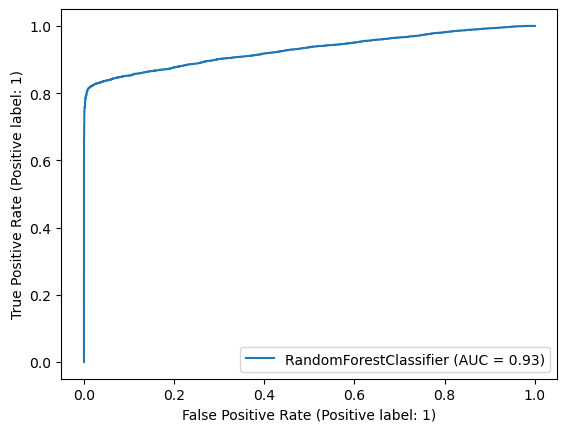

In [22]:
# Train and test model using hyper-paramters
good_model_RF = RandomForestClassifier(max_depth=12, 
                                    max_features = 'auto', 
                                    n_estimators=75,
                                    criterion='entropy', random_state = 11)

# create model 
print(good_model_RF) # display model parameters
good_model_RF.fit(xr_train, yr_train) # train model
pred = good_model_RF.predict(xr_test) # predicted output for test examples

# Printing results
print("Results on test data")
acc = accuracy_score(yr_test, pred) # accuracy on test examples
prec = precision_score(yr_test, pred) # precision on test examples
reca = recall_score(yr_test, pred) # recall on test examples
print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {prec: .4f}') # round to 4 decimal places
print(f'Test recall = {reca: .4f}') # round to 4 decimal places

# print Classification report
print("Classification report:")
print(classification_report(yr_test, pred))

# print Confusion matrix 
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(yr_test, pred)))

# print ROC curve
print('\nROC curve')
plot_roc_curve(good_model_RF, xr_test, yr_test)  
plt.show()

# XGB Classifier

In [23]:
modelXGB= XGBClassifier()
modelXGB.fit(xr_train, yr_train) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
pred_trainXGB = modelXGB.predict(xr_train)
pred_testXGB=modelXGB.predict(xr_test)

acc_trainXGB = accuracy_score(pred_trainXGB, yr_train)
acc_testXGB = accuracy_score(pred_testXGB, yr_test)
print(f'Training accuracy {acc_trainXGB: .3f}') 
print(f'Testing accuracy {acc_testXGB: .3f}')

Training accuracy  0.934
Testing accuracy  0.891


In [25]:
# hyperparameters to tune
param_grid = {'n_estimators':[150,170,200], 'max_depth': [17,19,21],'learning_rate':[0.5]} 

# grid search model
clf_XGB =GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = param_grid, cv=2, verbose=2, n_jobs=-1) 

# evaluate hyper-parameters
clf_XGB.fit(xr_train, yr_train) 

# best hyperparameter values
print("\nBest parameters found:")
print(clf_XGB.best_params_) 

print("\nGrid scores:")
means_ = clf_XGB.cv_results_['mean_test_score'] # mean accuracy with folds
stds_ = clf_XGB.cv_results_['std_test_score'] # standard deviation of accuracies

# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means_, stds_, clf_XGB.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 2 folds for each of 9 candidates, totalling 18 fits

Best parameters found:
{'learning_rate': 0.5, 'max_depth': 17, 'n_estimators': 150}

Grid scores:
0.440 (+/-0.033) for {'learning_rate': 0.5, 'max_depth': 17, 'n_estimators': 150}
0.436 (+/-0.044) for {'learning_rate': 0.5, 'max_depth': 17, 'n_estimators': 170}
0.433 (+/-0.037) for {'learning_rate': 0.5, 'max_depth': 17, 'n_estimators': 200}
0.397 (+/-0.050) for {'learning_rate': 0.5, 'max_depth': 19, 'n_estimators': 150}
0.398 (+/-0.068) for {'learning_rate': 0.5, 'max_depth': 19, 'n_estimators': 170}
0.396 (+/-0.049) for {'learning_rate': 0.5, 'max_depth': 19, 'n_estimators': 200}
0.357 (+/-0.034) for {'learning_rate': 0.5, 'max_depth': 21, 'n_estimators': 150}
0.353 (+/-0.025) for {'learning_rate': 0.5, 'max_depth': 21, 'n_estimators': 170}
0.352 (+/-0.055) for {'learning_rate': 0.5, 'max_depth': 21, 'n_estimators': 200}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=170, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=11,
              reg_alpha=None, reg_lambda=None, ...)
Results on test data
Test accuracy =  0.8847
Test precision =  0.9401
Test recall =  0.8622
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      5642
           1       0.94      0.86      

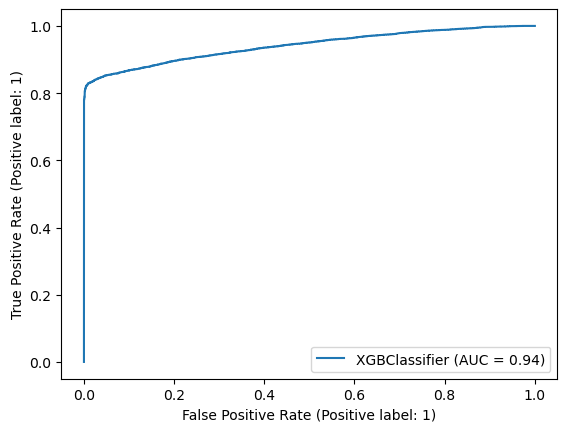

In [26]:
# Train and test model using hyper-parameters
good_model_XGB = XGBClassifier(max_depth =17, n_estimators=170, random_state = 11) 

# create model 
print(good_model_XGB) # display model parameters
good_model_XGB.fit(xr_train, yr_train) # train model
pred = good_model_XGB.predict(xr_test) # predicted output for test examples

# print results
print("Results on test data")
acc = accuracy_score(yr_test, pred) # accuracy on test examples
prec = precision_score(yr_test, pred) # precision on test examples
reca = recall_score(yr_test, pred) # recall on test examples
print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {prec: .4f}') # round to 4 decimal places
print(f'Test recall = {reca: .4f}') # round to 4 decimal places

# print Classification report 
print("Classification report:")
print(classification_report(yr_test, pred))

# print Confusion matrix 
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(yr_test, pred)))

# print ROC curve
print('\nROC curve')
plot_roc_curve(good_model_XGB, xr_test, yr_test)  # 
plt.show()

# KNN Classifier

In [27]:
modelknn= KNeighborsClassifier().fit(xr_train,yr_train)

In [28]:
pred_trainknn = modelknn.predict(xr_train)
pred_testknn=modelknn.predict(xr_test)

In [29]:
acc_trainknn = accuracy_score(pred_trainknn, yr_train)
acc_testknn = accuracy_score(pred_testknn, yr_test)
print(f'Training accuracy {acc_trainknn: .3f}') 
print(f'Testing accuracy {acc_testknn: .3f}')

Training accuracy  0.945
Testing accuracy  0.894


In [30]:
# hyperparameters to tune
tuned_parameters = [{'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                     'metric' : ['euclidean', 'minkowski'], 
                     'n_neighbors' : [5, 10, 20]}]
# grid search model
clfknn = GridSearchCV(KNeighborsClassifier(), tuned_parameters, verbose=1, n_jobs=-1)
 
# evaluate hyper-parameters
clfknn.fit(xr_train, yr_train)

# best hyperparameter values
print("\nBest parameters found:")
print(clfknn.best_params_) 

print("\nGrid scores:")
meansknn = clfknn.cv_results_['mean_test_score'] # mean accuracy with folds
stdsknn = clfknn.cv_results_['std_test_score'] # standard deviation of accuracies

# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansknn, stdsknn, clfknn.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found:
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5}

Grid scores:
0.864 (+/-0.011) for {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5}
0.808 (+/-0.017) for {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 10}
0.735 (+/-0.011) for {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 20}
0.864 (+/-0.011) for {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5}
0.808 (+/-0.017) for {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 10}
0.735 (+/-0.011) for {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 20}
0.864 (+/-0.011) for {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 5}
0.808 (+/-0.017) for {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 10}
0.735 (+/-0.011) for {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 20}
0.864 (+/-0.011) for {'algorithm': 'ball_tree', 'metric': 'm

KNeighborsClassifier(metric='euclidean')
Results on test data
Test accuracy =  0.8943
Test precision =  0.8770
Test recall =  0.9574
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      5642
           1       0.88      0.96      0.92      8387

    accuracy                           0.89     14029
   macro avg       0.90      0.88      0.89     14029
weighted avg       0.90      0.89      0.89     14029

Confusion matrix (Rows actual, Columns predicted):
      0     1
0  4516  1126
1   357  8030

ROC curve


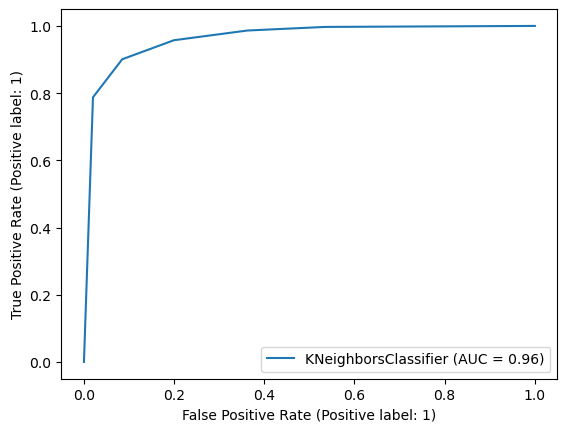

In [31]:
# Train and test model using hyper-parameters
good_model_knn = KNeighborsClassifier(algorithm='auto', metric='euclidean', n_neighbors=5)

# create model 
print(good_model_knn) # display model parameters
good_model_knn.fit(xr_train, yr_train) # train model
predknn = good_model_knn.predict(xr_test) # predicted output for test examples

# print results
print("Results on test data")
accknn = accuracy_score(yr_test, predknn) # accuracy on test examples
precknn = precision_score(yr_test, predknn) # precision on test examples
recaknn = recall_score(yr_test, predknn) # recall on test examples
print(f'Test accuracy = {accknn: .4f}') # round to 4 decimal places
print(f'Test precision = {precknn: .4f}') # round to 4 decimal places
print(f'Test recall = {recaknn: .4f}') # round to 4 decimal places

# print Classification report 
print("Classification report:")
print(classification_report(yr_test, predknn))

# print Confusion matrix 
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(yr_test, predknn)))

# print ROC curve
print('\nROC curve')
plot_roc_curve(good_model_knn, xr_test, yr_test)  
plt.show()

### **GETTING COMBINED RESULTS FROM THE TUNED MODELS** 

In [32]:
models_opt = []
models_opt.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'log_loss', max_features= 'sqrt',
                                                                      max_depth= 16, random_state = 11)))

models_opt.append(('Random Forest Classifier', RandomForestClassifier(max_features = 'auto', n_estimators = 75,
                                                           max_depth= 12, criterion = 'entropy', random_state = 11)))

models_opt.append(('XGB Classifier',XGBClassifier(max_depth = 17, n_estimators=150, random_state = 11, learning_rate =1)))

models_opt.append(('KNN Classifier', KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', algorithm='auto')))



In [33]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, model in models_opt:
    names_opt.append(name)
    kfold = model_selection.KFold(n_splits=10)
    
    cv_acc_results_opt = model_selection.cross_val_score(model, xr_train, yr_train, 
                    cv = kfold, scoring="accuracy")
    cv_auc_results_opt = model_selection.cross_val_score(model, xr_train, yr_train,
                    cv = kfold, scoring="roc_auc")
    cv_pre_results_opt = model_selection.cross_val_score(model, xr_train, yr_train,
                    cv = kfold, scoring="precision")
    cv_f1_results_opt = model_selection.cross_val_score(model, xr_train, yr_train,
                    cv = kfold, scoring="f1")
    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    model_results_opt.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt.sort_values(by = ['Accuracy'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,F1 Scores
1,Random Forest Classifier,92.92,88.37,96.71,89.66
3,KNN Classifier,95.07,87.87,86.39,90.42
2,XGB Classifier,93.74,87.62,92.30,89.42
0,Decision Tree Classifier,85.73,81.67,88.09,84.13


In [34]:
model_results.sort_values(by = ['Accuracy'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,f1 Score
2,XGB Classifier,82.79,59.75,68.48,24.34
0,Random Forest Classifier,76.34,57.15,31.06,25.88
1,Decision Tree Classifier,71.56,55.09,26.51,27.43
3,KNN Classifier,78.14,53.40,23.96,11.71


## Pickling the model

In [35]:
filename = 'model1.sav'
pickle.dump(good_model_RF, open(filename, 'wb'))
load_model = pickle.load(open(filename, 'rb'))
good_model_RF_r1 = load_model.score(xr_test, yr_test)
good_model_RF_r1

0.8845249126808753